Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from collections import Counter
from typing import List
import string

from sklearn.metrics import r2_score

import seaborn
seaborn.set(palette='summer')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Загрузка данных:

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/cleaned data Guilford.xlsx')
dataset = pd.read_excel('cleaned data Guilford.xlsx')

In [ ]:
target_values = dataset['prepr_text'].values() # для лемм - lemm_text, для стемм - stemm_text

In [ ]:
dataset

,Unnamed: 0,ID,attempt,n,answer,origNew,simple_category,stemm_text
0,0,PTxGzRMvLY,1,1,сложить из спичек домик,3,5,слож спичк домик
1,1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,5,6,использова спичк опор ниб
2,2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,3,6,спичк мжны ковыря зуб
3,3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",5,6,слож спичк вид колодец использоватькак подставк
4,4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",2,5,разукрас спичк слож листочек поделк
...,...,...,...,...,...,...,...,...
6718,9256,2008_2009_320,0,2,для поджога мусора,4,1,поджог мусор
6719,9257,2008_2009_320,0,3,для играния,3,7,игран
6720,9258,2008_2009_321,0,1,зубочистка - зубы чистить,3,6,зубочистк зуб чист
6721,9259,2008_2009_321,0,2,как палочка - для игр,3,7,палочк игр


# Создание словаря:

In [ ]:
%%time
words = Counter()

for answer in tqdm(target_values):
  # !!! разкомментить для пословного кодирования
  #answer_words = answer.split()
  #for word in answer_words:
  for word in answer:
    words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])

# порог вхождения слова в словарь
counter_threshold = 3

for char, cnt in words.items():
  if cnt > counter_threshold:
    vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2id = {char: i for i, char in enumerate(vocab)}
id2word = {i: char for char, i in word2id.items()}

  0%|          | 0/6723 [00:00<?, ?it/s]

Размер словаря: 41
CPU times: user 82.9 ms, sys: 0 ns, total: 82.9 ms
Wall time: 86.8 ms


In [ ]:
# ВКЛЮЧЕНИЕ Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = np.array(dataset['origNew'].values)

# Преобразуйте данные в массив с одним столбцом
reshaped_data = data.reshape(-1, 1)

scaled_orig = scaler.fit_transform(reshaped_data)
dataset['origNew'] = scaled_orig
dataset

,Unnamed: 0,ID,attempt,n,answer,origNew,simple_category,stemm_text
0,0,PTxGzRMvLY,1,1,сложить из спичек домик,-1.371116,5,слож спичк домик
1,1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,0.862471,6,использова спичк опор ниб
2,2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,-1.371116,6,спичк мжны ковыря зуб
3,3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",0.862471,6,слож спичк вид колодец использоватькак подставк
4,4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",-2.487910,5,разукрас спичк слож листочек поделк
...,...,...,...,...,...,...,...,...
6718,9256,2008_2009_320,0,2,для поджога мусора,-0.254323,1,поджог мусор
6719,9257,2008_2009_320,0,3,для играния,-1.371116,7,игран
6720,9258,2008_2009_321,0,1,зубочистка - зубы чистить,-1.371116,6,зубочистк зуб чист
6721,9259,2008_2009_321,0,2,как палочка - для игр,-1.371116,7,палочк игр


# Разбиение на трейн/тест:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(target_values, dataset['origNew'].values,
                                                    test_size=0.2, random_state=42)

In [ ]:
class WordDataset:
    def __init__(self, sentences,y):
        self.data = sentences
        self.y = y
        self.unk_id = word2id['<unk>']
        self.bos_id = word2id['<bos>']
        self.eos_id = word2id['<eos>']
        self.pad_id = word2id['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]
        tokenized_sentence = [self.bos_id]
        # !!! разкомментить для пословного кодирования
        #tokenized_sentence += [word2id.get(word, self.unk_id) for word in processed_text.split()]
        tokenized_sentence += [word2id.get(word, self.unk_id) for word in processed_text]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.y[idx]
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2id['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.FloatTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(X_train, y_train)

np.random.seed(42)
eval_dataset = WordDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
train_dataset[1]

{'text': [2, 5, 25, 18, 1, 30, 27, 9, 27, 17, 27, 3, 33, 13],
 'label': 0.8624711327140552}

Про метрики:

_**Коэффициент детерминации (R-squared)** указывает на пропорциональный объем изменения переменной отклика y, объясненный независимыми переменными X в модели линейной регрессии. Чем больше R-squared, тем больше изменчивости объяснено моделью линейной регрессии._

_**Функция потерь MSE** широко используется в линейной регрессии в качестве показателя эффективности. Чтобы рассчитать MSE, надо взять разницу между предсказанными значениями и истинными, возвести ее в квадрат и усреднить по всему набору данных._

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

def evaluate_regression(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            logits = logits.reshape(1,-1)[0].cpu()
            predictions.extend(logits)
            target.extend(batch['label'].cpu())

    accuracy = r2_score(target, predictions)

    return accuracy

# Модель №1 регрессия RNN

In [ ]:
class CharLM(nn.Module):
    def __init__(
        # !!! изменили выход последнего слоя на 1, так как решаем задачу регрессии для предсказания балла по оригинальности
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        return prediction

In [ ]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(1,-1)[0], batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate_regression(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

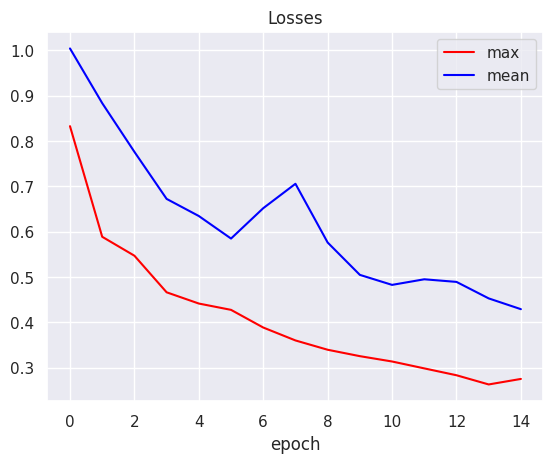

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 57.20
Лучшая accuracy для подхода mean: 56.14


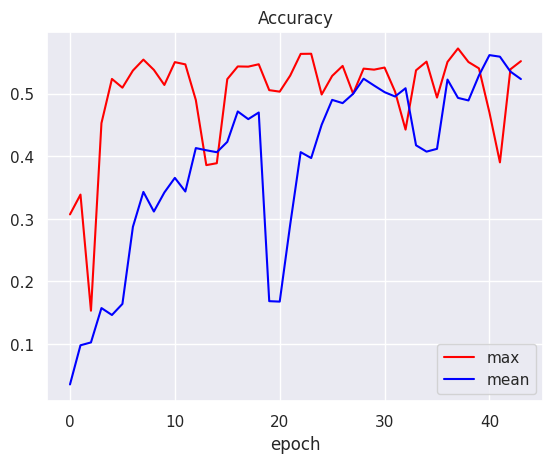

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Модель №2 GRU

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(1,-1)[0], batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate_regression(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

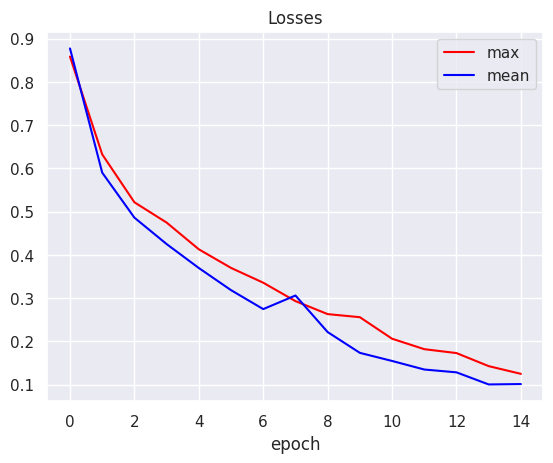

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 57.47
Лучшая accuracy для подхода mean: 58.42


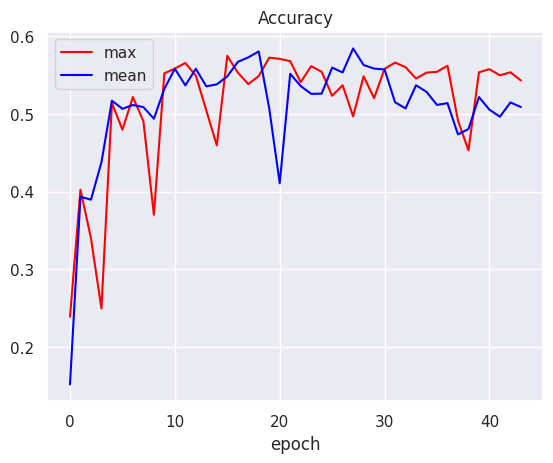

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Модель №3 LSTM

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 20
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=1024, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(1,-1)[0], batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate_regression(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/169 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/169 [00:00<?, ?it/s]

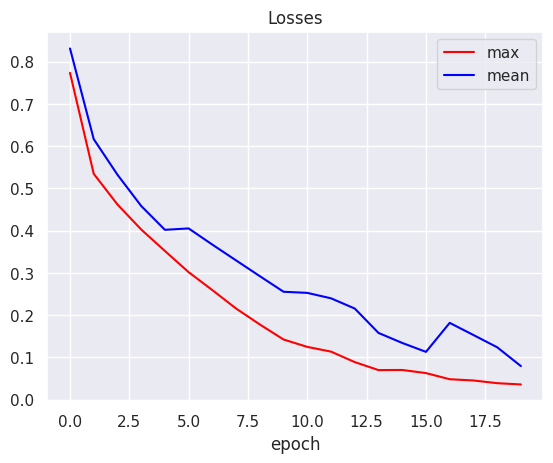

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 60.99
Лучшая accuracy для подхода mean: 59.07


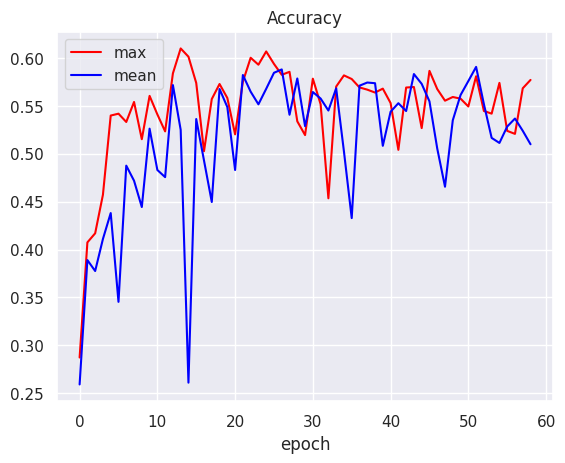

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Модель №4. Увеличение количества рекуррентных слоев модели + добавим количество эпох, так как на данный момент не видим переобучения модели

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # !!! сделаем 2 слоя в RNN
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(1,-1)[0], batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate_regression(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

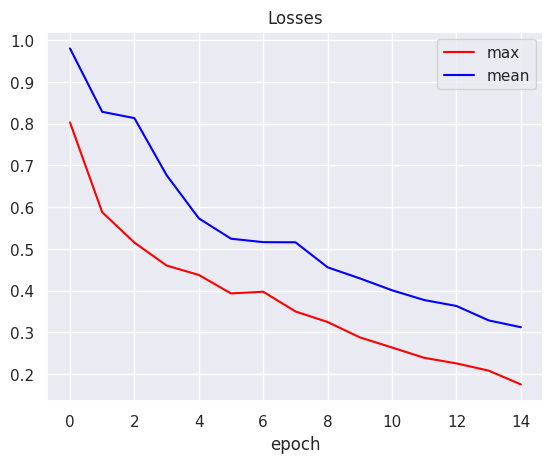

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 59.15
Лучшая accuracy для подхода mean: 54.93


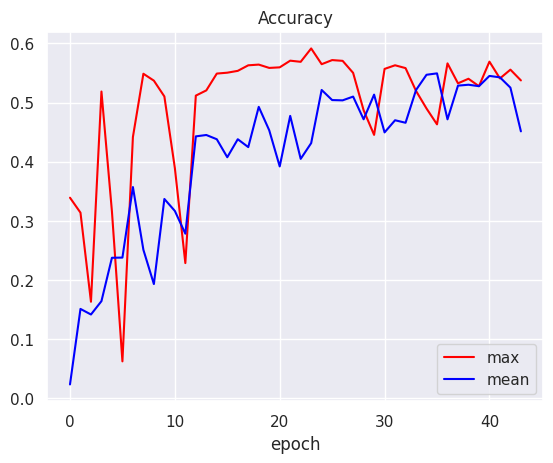

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Модель №5 Подбор гиперпараметров

In [ ]:
# !!! выставляем длину вектора 512 для данного и последующих экспериментов

def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2id['<pad>'], max_len=512) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.FloatTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(X_train, y_train)

np.random.seed(42)
eval_dataset = WordDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # !!! сделаем 2 слоя в GRU и двунаправленность
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=True)

        # !!! Увеличиваем размер слоя, так как у нас двунаправленная LSTM, а выход делаем в 2 раза меньше входного
        self.linear = nn.Linear(hidden_dim*2, hidden_dim//2)
        self.projection = nn.Linear(hidden_dim//2, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        #output = output[:, -1]
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(1,-1)[0], batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate_regression(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

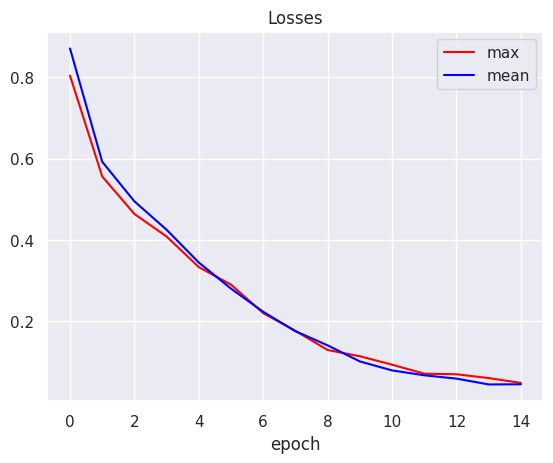

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 61.26
Лучшая accuracy для подхода mean: 57.95


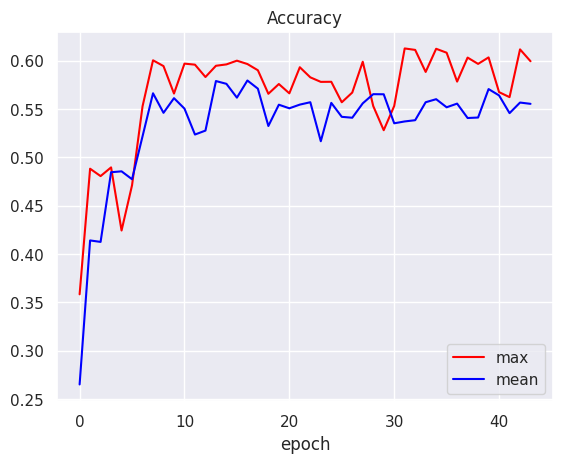

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Модель №6 Конкатенация результата агрегирования и последнего выхода из LSTM

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # !!! сделаем 2 слоя в GRU и двунаправленность
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=True)

        # !!! Увеличиваем размер слоя, так как у нас двунаправленная GRU + размер последнего выхода из GRU
        self.linear = nn.Linear(hidden_dim*2 + hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        # !!! берем последний выход из GRU
        output_last = output[:, -1]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        # !!! объединяем агрегированный вектор и выход последнего слоя LSTM в один длинный вектор
        output = torch.cat((output,output_last), 1)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.dropout(self.relu(output)))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 30
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(1,-1)[0], batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate_regression(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/169 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/169 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/169 [00:00<?, ?it/s]

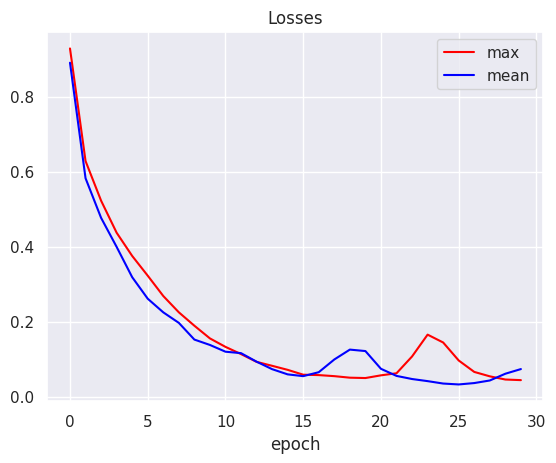

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 63.00
Лучшая accuracy для подхода mean: 62.98


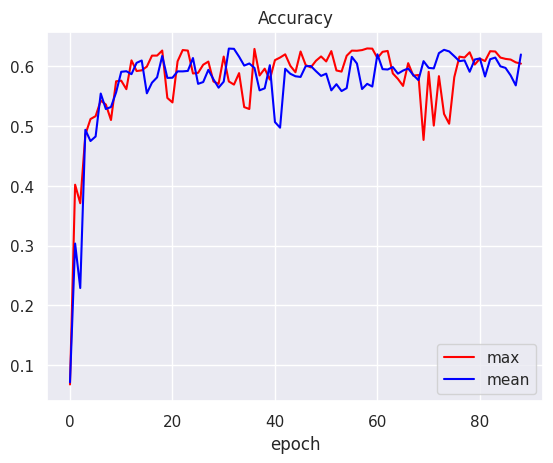

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()